# The WASP 18 System

## Learning Goals:

This notebook will present the data for WASP 18b as observed by TESS. Data presented here will complement those derived from the JWST early release science. 

The notebook will teach the user how to do the following:

1. Search TESS for data on the WASP-18 system using *Lightkurve*.
2. Download a light curve.
3. Find the transiting planet via a Lomb-Scargle periodogram analysis.
4. Bin the folded light curve to highlight additional information about the system.
5. How to account for instrumental and noise effects within your data using the Corrector class.

To learn more about the TESS mission in general and the various data products please visit the [TESS Science Support Center](https://heasarc.gsfc.nasa.gov/docs/tess/).

## Introduction: 
The WASP 18 system is located approximately 400 light-years from the Earth in the Phoenix constellation of the southern hemisphere. It has an F-type host star which is roughly 25% more massive than our own Sun.

The host star is home to two planets WASP-18 b and WASP-18 c. Our tutorial will focus on WASP-18 b, a gas giant which is about 10 times the mass of Jupiter and 24% larger in size. The planet takes only 0.9 days to orbit its host star. Given its proximity to its host, this planet is baked to a scorching temperature of 4,800 degrees Fahrenheit!

Given the close proximity of WASP-18b to its host star and the fact that the planet glows brightly in the IR, a secondary eclipse is observable in this system. Secondary eclipses occur when a transiting planet disappears behind its host, not when it crosses in front. This makes the system particularly interesting for observation by JWST. By comparing the two measurements, one taken when both star and planet are visible, and the other when only the star is in view, astronomers can calculate how much light is coming from the planet alone.

Astronomers also aim to use JWST to examine the planet’s stratosphere.

For this tutorial we will look at obtaining the transit sand secondary eclipse signals for WASP 18b. 

## Imports

This tutorial requires the [*Lightkurve package*](https://docs.lightkurve.org/index.html), [Matplotlib](https://matplotlib.org/) which we use for plotting, [Numpy](https://numpy.org/), and also [Astropy](https://www.astropy.org/) which we use for the units package.

In [1]:
%matplotlib inline 
import lightkurve as lk 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import astropy.units as u
import numpy as np

import warnings
warnings.filterwarnings("ignore")

## First time users: 

If you are not that experienced with Python, or cannot download *Lightkurve*, you can run this notebook as a [Google Colab notebook](https://colab.research.google.com/?utm_source=scs-index). Colaboratory allows users to write and execute Python in your browser with zero configuration required.

All you need is a Google account and to copy and paste in the following command at the top of your colab notebook:

`!pip install lightkurve --quiet`

This downloads the Lightkurve package.

## 1. Search TESS for data on the WASP-18 system using *Lightkurve*.

Lightkurve offers a user-friendly way to analyze time series data obtained by the TESS mission. You can search for the various WASP-18 data products using the following functions:

- To the system in a full frame image: [`search_tesscut()`](https://docs.lightkurve.org/reference/api/lightkurve.search_tesscut.html?highlight=search_tesscut)
- To look for target pixel files: [`search_targetpixelfile()`](https://docs.lightkurve.org/reference/api/lightkurve.search_targetpixelfile.html?highlight=search_targetpixelfile)
- To obtain light curve files for WASP-18: [`search_lightcurve()`](https://docs.lightkurve.org/reference/api/lightkurve.search_lightcurve.html?highlight=search_lightcurve)


### 1.1 Accessing the data products
Let’s go through each one of the above functions and see what data is available.

In [2]:
search_ffi = lk.search_tesscut('WASP18')
search_tpf = lk.search_targetpixelfile('WASP18')
search_lcf = lk.search_lightcurve('WASP18')

In [3]:
search_ffi

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,TESScut,1426,WASP18,0.0
1,TESS Sector 03,2018,TESScut,1426,WASP18,0.0
2,TESS Sector 29,2020,TESScut,475,WASP18,0.0
3,TESS Sector 30,2020,TESScut,475,WASP18,0.0


The above table provides several important pieces of information: 

- The sector in which the object was observed. 
- The year in which the object was observed. 
- The author of the data. This can have multiple options and each is a hyperlink that when clicked will provide you with more information. 
- The cadence of the observation. 
- The name of the target. 
- The distance of the observation from your target of interest. This is useful if you conduct a cone search around your objects co-ordinates.

The table indicates that our object was observed in sectors 2, 3, 29, and 30.

Let’s see if any other data exists, i.e., was it observed as a target of interest and does it have a Target Pixel File.

In [4]:
search_tpf

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,SPOC,120,100100827,0.0
1,TESS Sector 02,2018,TESS-SPOC,1800,100100827,0.0
2,TESS Sector 03,2018,SPOC,120,100100827,0.0
3,TESS Sector 03,2018,TESS-SPOC,1800,100100827,0.0
4,TESS Sector 29,2020,SPOC,20,100100827,0.0
5,TESS Sector 29,2020,SPOC,120,100100827,0.0
6,TESS Sector 29,2020,TESS-SPOC,600,100100827,0.0
7,TESS Sector 30,2020,SPOC,20,100100827,0.0
8,TESS Sector 30,2020,SPOC,120,100100827,0.0


Our object was observed as a target of interest and has several cadences of data, and several kinds of data products i.e, SPOC or TESS-SPOC. Given that there is SPOC data this means that there should be light curve files for our object already in the archive. Let’s check those out.

In [5]:
search_lcf

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,SPOC,120,100100827,0.0
1,TESS Sector 02,2018,TESS-SPOC,1800,100100827,0.0
2,TESS Sector 02,2018,QLP,1800,100100827,0.0
3,TESS Sector 02,2018,TASOC,120,100100827,0.0
4,TESS Sector 02,2018,GSFC-ELEANOR-LITE,1800,100100827,0.0
5,TESS Sector 02,2018,TASOC,1800,100100827,0.0
6,TESS Sector 02,2018,TASOC,1800,100100827,0.0
7,TESS Sector 03,2018,SPOC,120,100100827,0.0
8,TESS Sector 03,2018,TESS-SPOC,1800,100100827,0.0


Wonderful! Light curves for our object of interest have already been created.

## 2. Download a light curve:
We will now obtain the light curve for our object of interest. From the above table, it looks like there are multiple authors for our target. For the purpose of this tutorial, let’s stick to “SPOC” data products. We can return only these results using the following commands.

In [6]:
search_lcf_refined = lk.search_lightcurve('WASP18', author="SPOC")
search_lcf_refined

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,SPOC,120,100100827,0.0
1,TESS Sector 03,2018,SPOC,120,100100827,0.0
2,TESS Sector 29,2020,SPOC,20,100100827,0.0
3,TESS Sector 29,2020,SPOC,120,100100827,0.0
4,TESS Sector 30,2020,SPOC,20,100100827,0.0
5,TESS Sector 30,2020,SPOC,120,100100827,0.0


There are five light curves from four sectors: 2 and 3, 29 and 30. Sectors 29 and 30 have both 20-second and 120-second cadence light curves. For this tutorial we will use the most recent data, sector 30, with the 20 second cadence. 

In [7]:
lk_s30f = search_lcf_refined[4].download(quality_bitmask='hard')

We can easliy plot these data using the following code;

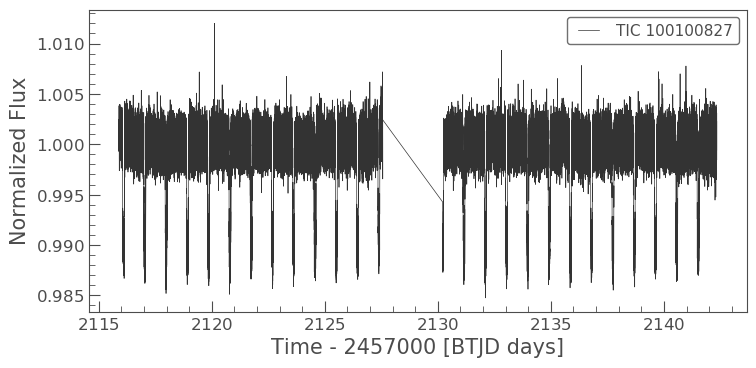

In [8]:
lk_s30f.normalize().remove_outliers().plot()

Note that the [`normalize`](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.normalize.html?highlight=normalize#lightkurve.LightCurve.normalize) and [`remove_outliers`](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.remove_outliers.html?highlight=remove_outliers) functions were used here to present a more refined light curve. The plot above present a very clear transit signal, but not an obvious secondary eclipse. 

We can use this light curve to find the exact period of the transit and perhaps refine it further to find the secondary eclipse signal.

## 3. Find the transiting planet via a Lomb-Scargle periodogram analysis.

A common method used to identify transiting exoplanets is via Lomb-Scargle periodogram analysis. The Lomb–Scargle periodogram is essentially an algorithm used to detect and characterize periodic signals in unevenly sampled data e.g., light curves (please see the [Creating a Periodogram from Kepler Data](https://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html?highlight=lomb) for more information on Lomb–Scargle periodograms and finding exoplanets with *Lightkurve*)

We can create a periodogram for WASP-18 using the [`to_periodogram`](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.to_periodogram.html?highlight=to_periodogram)  function. First, however we want to normalize the flux units to parts per million (ppm), which gives a more intuitive impression of the relative power of these oscillations. 

We can also refine our periodogram based on the system parameters listed at the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/). The period listed for WASP-18b is 0.94145 days.

In [9]:
period0 = 0.94145

In [10]:
pg = lk_s30f.normalize(unit='ppm').to_periodogram(minimum_period = period0*.8,
                      maximum_period = period0*1.2,
                      oversample_factor=100)
pg

LombScarglePeriodogram(ID: TIC 100100827)

We now have LombScarglePeriodogram object called `pg`. This object contains all of the properties of the Periodogram class, as well as some features unique to Lomb-Scargle periodograms which you can learn about in the *Lightkurve* tutorial entitled ["Measuring and removing a rotation period signal from a light curve"](https://docs.lightkurve.org/tutorials/3-science-examples/periodograms-measuring-a-rotation-period.html).

For now, lets plot our periodogram.

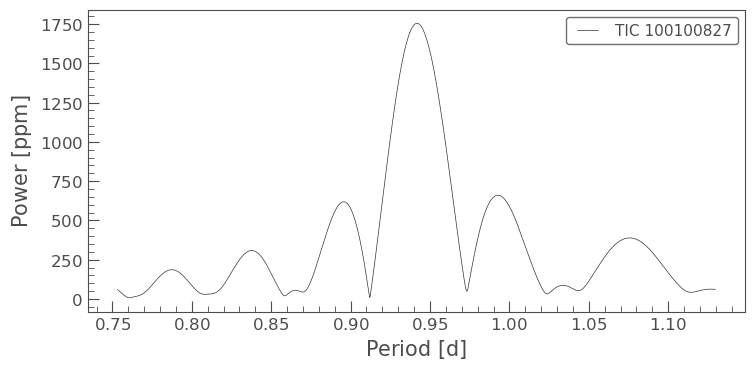

In [11]:
pg.plot()

The plot seems to suggest that there are many different signals, but these peaks are likely alias harmonics of the true oscillation frequency.

Repeating harmonic peaks and aliasing is a common issue in frequency-domain analysis, particularly when the time-domain signal isn’t exactly shaped like a sine wave, as is the case here.

To get the orbital period of our planet we can look at the period of the highest peak. A Periodogram object will store a number of details about the periodogram, which can be accessed through the [`show_properties()`](https://docs.lightkurve.org/reference/api/lightkurve.periodogram.Periodogram.show_properties.html?highlight=show_properties) method. 


In [12]:
pg.show_properties()

lightkurve.Periodogram properties:
      Attribute         Description   Units
---------------------- -------------- -----
                nterms              1      
              targetid      100100827      
          default_view         period      
                 label  TIC 100100827      
             ls_method           fast      
frequency_at_max_power         1.0617 1 / d
             max_power      1754.9963   ppm
               nyquist      2160.0357 1 / d
   period_at_max_power         0.9419     d
             frequency  array (1171,) 1 / d
                period  array (1171,)     d
                 power  array (1171,)   ppm
                  meta <class 'dict'>      


There is lots of information here that you can learn more about from the [Creating periodograms and identifying significant peaks](https://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html?highlight=lomb#2.-Creating-a-Periodogram-from-Kepler-Data) tutorial, but what we are interested in is the `period_at_max_power` parameter. This is listed as 0.9419 days, similar to what we found in the archive. 

Let’s extract this value, and then use the [`fold()`](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.fold.html?highlight=fold#lightkurve.LightCurve.fold) function to see if we can see our transit more clearly.

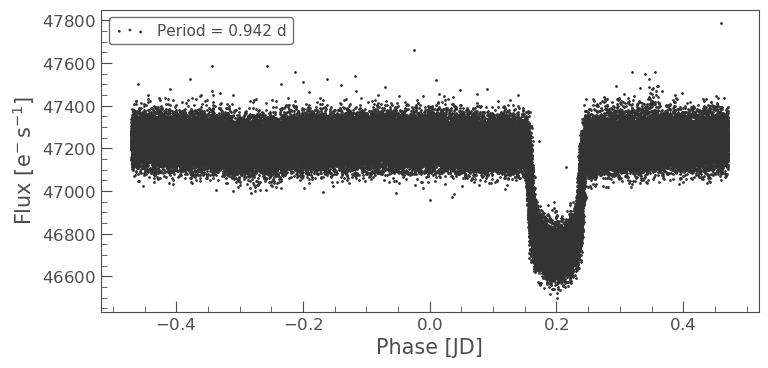

In [13]:
period = pg.period_at_max_power
folded_lc = lk_s30f.fold(period)
folded_lc.scatter(label=f'Period = {period.value:.3f} d')

Wonderful we have now recovered the transit signal for WASP-18b. Once again however, we cannot see the secondary eclipse. This could be because it is lost in all the data presented.

Binning the data might aid with observing the eclipse and so we are now going to bin our folded light curve to 3-minute intervals. We can do this using the [`bin()`](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.bin.html?highlight=bin#lightkurve.LightCurve.bin) function. We will then overplot this binned light curve on our folded one.

In [14]:
flc = folded_lc.normalize()
binned_lc = folded_lc.bin(time_bin_size=3*u.minute).normalize()

(-10, 10)

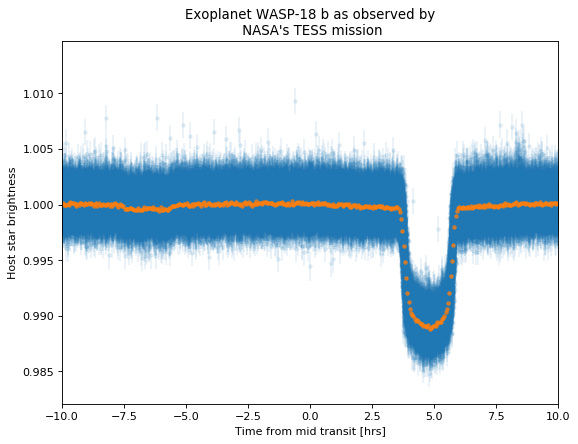

In [15]:
figure(figsize=(8, 6), dpi=80)
plt.errorbar(flc.phase.value*24, flc.flux.value, fmt=".", alpha=0.1, yerr=flc.flux_err.value)
plt.errorbar(binned_lc.phase.value*24, binned_lc.flux.value, fmt=".", alpha=0.7, yerr=binned_lc.flux_err.value)
plt.title("Exoplanet WASP-18 b as observed by\n NASA's TESS mission")
plt.xlabel("Time from mid transit [hrs]")
plt.ylabel("Host star brightness")
plt.xlim(-10,10)

Great! We can now see the secondary eclipse in our data. This is the very shallow dip to the left of the transit. We highlight this in the plot below.

(-10, 10)

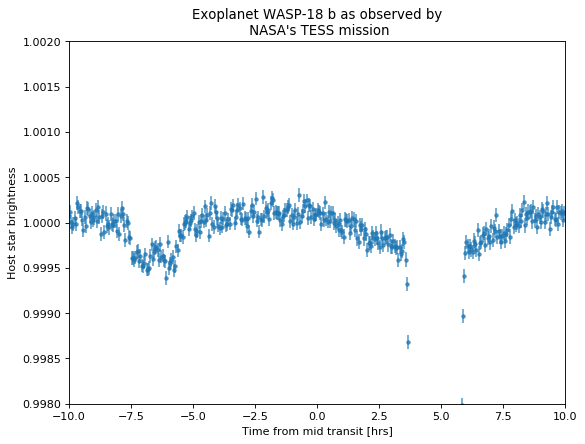

In [16]:
figure(figsize=(8, 6), dpi=80)
plt.errorbar(binned_lc.phase.value*24, binned_lc.flux.value, fmt=".", alpha=0.7, yerr=binned_lc.flux_err.value)
plt.title("Exoplanet WASP-18 b as observed by\n NASA's TESS mission")
plt.xlabel("Time from mid transit [hrs]")
plt.ylabel("Host star brightness")
plt.ylim(0.998,1.002)
plt.xlim(-10,10)

But hang on, something looks a little odd in that secondary eclipse. The data seems to be showing multiple dips, this does not look right. Could this be caused by residual noise that has not properly been subtracted from the light curve via the SPOC pipeline?

Let's go back to the light curve again and using the Simple Aperture Photometry (SAP) flux only, re-reduce the light curve ourselves. 

## 5. How to account for instrumental and noise effects within your data using the Corrector class.

We can obtain the SAP light curve via the following code.

In [17]:
lc = lk.search_lightcurve('WASP 18', author='SPOC', sector=30, exptime=120).download(flux_column='sap_flux')

### 5.1 Introduction to the Corrector Class

*TESS* light curves can often have systematic trends caused by noise sources such as scattered light and instrumental effects. Only the [LightCurve objects](https://docs.lightkurve.org/tutorials/1-getting-started/what-are-lightcurve-objects.html) which have been fully processed, have had these effects removed. Data derived from either [TargetPixelFiles](https://docs.lightkurve.org/tutorials/1-getting-started/what-are-targetpixelfile-objects.html) or Full Frame Images must undergo further processing by the user to remove these sources of noise. 

To aid the user in this process, there exist several different tools within the 
*Lightkurve* package. These are known as the [Corrector class](https://docs.lightkurve.org/reference/api/lightkurve.correctors.corrector.Corrector.html?highlight=corrector%20class#lightkurve-correctors-corrector-corrector).

For the purpose of this tutorial we will use CBVs to remove our noise. 

- [**CBVCorrector**](https://docs.lightkurve.org/reference/api/lightkurve.correctors.CBVCorrector.html?highlight=cbvcorrector): Cotrending Basis Vectors (CBVs) are generated from the most common systematic trends observed in each Sector. Each *TESS* CCD and Camera has its own set of CBVs. There are three basic types of CBVs, 
  - **Single-Scale**: Contains all systematic trends combined in a single set of basis vectors. Generally speaking, a single-scale CBV performs better at preserving longer period signals.
  - **Multi-Scale**: Contains systematic trends in specific wavelet-based band passes. There are usually three sets of multi-scale basis vectors in three bands. This type of correction performs better when the periods are close to the transiting planet durations, and help to preserve the signal.
  - **Spike**: Contains only short impulsive spike systematics. This correction is applied to remove short impulsive systematic signals.
  
Check out our [CBV tutorial](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-how-to-use-cbvcorrector.html) for more information.

First, we must import the *CBVCorrector* from *lightkurve.correctors*, and then we can refer to our generate light curve.

In [18]:
from lightkurve.correctors import CBVCorrector
cbvCorrector = CBVCorrector(lc)

In [19]:
cbvCorrector.cbvs

[TESS CBVs, Sector.Camera.CCD : 30.2.1, CBVType : SingleScale, nCBVS : 16,
 TESS CBVs, Sector.Camera.CCD : 30.2.1, CBVType.Band: MultiScale.1, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 30.2.1, CBVType.Band: MultiScale.2, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 30.2.1, CBVType.Band: MultiScale.3, nCBVs : 5,
 TESS CBVs, Sector.Camera.CCD : 30.2.1, CBVType : Spike, nCBVS : 5]

There are 5 sets of CBVs, all associated with Sector 30, Camera 2, CCD 1. The number of CBVs per type is also given. Let’s plot the Single-Scale CBVs, which contain all systematics combined.

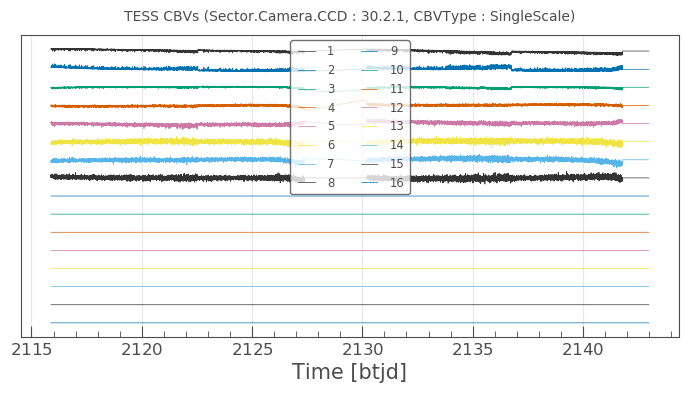

In [20]:
cbvCorrector.cbvs[0].plot();

The first several CBVs contain most of the systematics. The latter CBVs pose a greater risk of injecting more noise than helping. The default behavior in CBVCorrector is to use the first 8 CBVs.

Next, we need to decide what kind of CBV we want to apply. We are going to use the Single-Scale and Spike options (see above for more details). We can specify the type via an array as indicated below.

In [21]:
cbv_type = ['SingleScale', 'Spike']

Since we only want to use the information from the first 8 CBV's when we use the SingleScale function, and all the Spike CBCs, we must also specify this via an array.

In [22]:
cbv_indices = [np.arange(1,9), 'ALL']

We now want to apply the correction and see what it looks like.

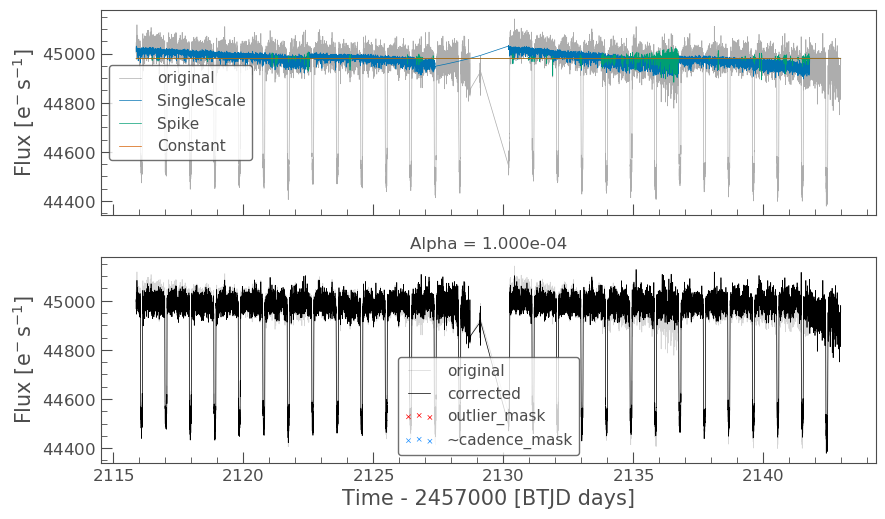

In [23]:
cbvCorrector.correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices, alpha=1e-4)
cbvCorrector.diagnose();

First, note that CBVCorrector always fits a constant term in the model, but the constant is never subtracted in the resultant corrected flux. The median flux value of the light curve is always preserved.

At first sight, this looks like a good correction. Both the Single-Scale and Spike basis vectors are being utilized to fit out as much of the signal as possible. The corrected light curve is indeed flatter. But this was essentially an unrestricted least-squares correction and we may have over-fitted.

Let’s look at the CBVCorrector goodness metrics to determine if this is the case. 

In [24]:
print('Over fitting Metric: {}'.format(cbvCorrector.over_fitting_metric()))
print('Under fitting Metric: {}'.format(cbvCorrector.under_fitting_metric()))

Over fitting Metric: 0.8690866392645524
Under fitting Metric: 0.9993064659669575


A goodness metric of 0.8 or above is generally considered good. It looks like we have indeed found a good fit for our data! We can now re-name this corrected light curve and find the period again.

In [25]:
corrected_lc =  cbvCorrector.correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices, alpha=1e-4)

### 5.3 Re-deriving the period using the corrected light curve

Once again we will use the Lomb-Scargle periodogram analysis. This time lets use our perviously defined period as an initial start.

In [26]:
pg2 = corrected_lc.normalize(unit='ppm').to_periodogram(minimum_period = period0*.80,
                      maximum_period = period0*1.2,
                      oversample_factor=100)
pg2

LombScarglePeriodogram(ID: TIC 100100827)

Again we can plot this and view the information.

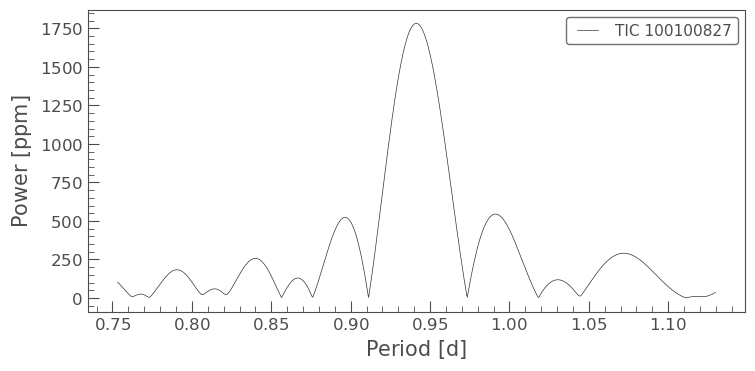

In [27]:
pg2.plot()

In [28]:
pg2.show_properties()

lightkurve.Periodogram properties:
      Attribute         Description   Units
---------------------- -------------- -----
                nterms              1      
              targetid      100100827      
          default_view         period      
                 label  TIC 100100827      
             ls_method           fast      
frequency_at_max_power         1.0623 1 / d
             max_power      1782.8153   ppm
               nyquist       360.0061 1 / d
   period_at_max_power         0.9414     d
             frequency  array (1200,) 1 / d
                period  array (1200,)     d
                 power  array (1200,)   ppm
                  meta <class 'dict'>      


In [29]:
pg2.period_at_max_power

<Quantity 0.9413674 d>

Using our corrected light curve we have found a period of 0.9414 days which is very similar to values in the literature. We can now use this to fold the data and view the transit and secondary eclipse.

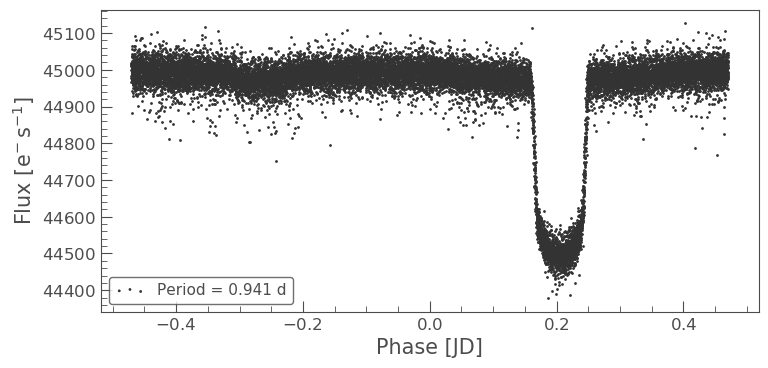

In [30]:
period2 = pg2.period_at_max_power 
folded_lc2 = corrected_lc.fold(period2)
folded_lc2.scatter(label=f'Period = {period2.value:.3f} d')

We can see a hint of the secondary eclipse. Let us now bin the data again.

In [31]:
lc2 = folded_lc2.bin(time_bin_size=3*u.minute).normalize().remove_outliers()

(-10, 10)

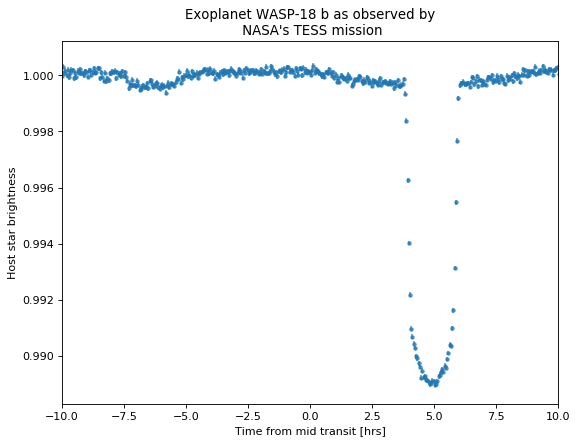

In [32]:
figure(figsize=(8, 6), dpi=80)
plt.errorbar(lc2.phase.value*24, lc2.flux.value, fmt=".", alpha=0.7, yerr=lc2.flux_err.value)
plt.title("Exoplanet WASP-18 b as observed by\n NASA's TESS mission")
plt.xlabel("Time from mid transit [hrs]")
plt.ylabel("Host star brightness")
plt.xlim(-10,10)

(-10, 10)

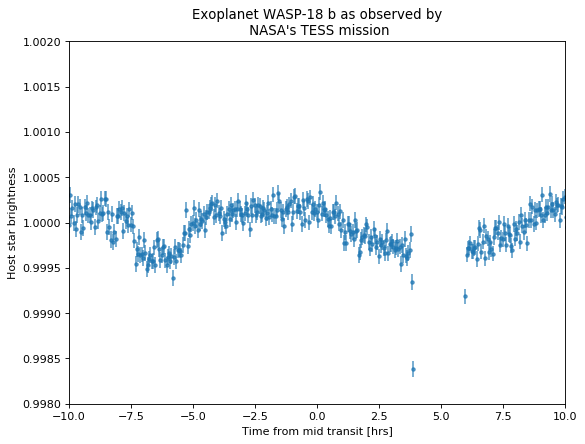

In [33]:
figure(figsize=(8, 6), dpi=80)
plt.errorbar(lc2.phase.value*24, lc2.flux.value, fmt=".", alpha=0.7, yerr=lc2.flux_err.value)
plt.title("Exoplanet WASP-18 b as observed by\n NASA's TESS mission")
plt.xlabel("Time from mid transit [hrs]")
plt.ylabel("Host star brightness")
plt.ylim(0.998,1.002)
plt.xlim(-10,10)

Wonderful! We have now re-obtained the transit and the secondary eclipse does not seem to have those strange dips any more. 